# Finding location neurons
A location neurons are neurons which are activated when animal is located in particular place. In this notebook few methods of identifying such neurons will be suggested.
## Method 1. Use by-neuron spatial information

<p>Considering all positions where mouse was we can divide arena in parts which will be called as "bins" further. Such a division can be made by $k$-means algorithm.</p>
<p> The spatial information score is the probability of a mouse being in particular place(i.e. bean) multiplied on the mean value of mouse being in a particular bin when neuron is active. In mathematical terms:
    $$
    \displaystyle
    SI=\sum_{i=1}^{n} \theta(a_i-a_{min})\mathbf{P}(p\in B_i)\mathbf{E}(a|p\in B_i)log_2\left(\frac{\mathbf{E}(a|p\in B_i)}{\mathbf{E}(a)}\right)
    $$
</p>
<p> In order to find best neurons we take $n$ neurons with the highest $SI$ score.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from tqdm import trange,tqdm
from math import *

In [2]:
atRoot = 'atRoot' in vars()
if not atRoot:
    os.chdir("..")
atRoot = True

In [3]:
DATASET="data/22ht1_normalized.csv" # Dataset path
N_BINS=10 # How many bins to use 

data=pd.read_csv(DATASET)

In [4]:
extract_pos = lambda data: pd.DataFrame({"x": data["x"],"y": data["y"]},columns = ["x", "y"])
unique = lambda data: list(set(data))
def make_bins(data):
    kmeans = KMeans(n_clusters=N_BINS).fit(data)
    return kmeans.labels_

In [5]:
def calc_p_in_bin(labels):
    p_in_bin=dict()
    for b in labels:
        if b not in p_in_bin:
            p_in_bin[b]=1
        else:
            p_in_bin[b]+=1
    for key in p_in_bin:
        p_in_bin[key]/=len(labels)
    return p_in_bin

In [6]:
labels = make_bins(extract_pos(data))
p_in_bin = calc_p_in_bin(labels)
def si_score(activity, labels, activity_threshold=0.3):
    assert len(activity)==len(labels)
    score=0.0
    exp_activity=np.mean(activity)
    for i in range(len(activity)):
        if activity[i]<activity_threshold:
            continue
        pos=labels[i]
        activity_in_pos = np.mean(activity[labels == pos])
        p_prob=p_in_bin[labels[i]]
        if not np.allclose(activity_in_pos,0.0):
            score+=p_prob*activity_in_pos*np.log2(activity_in_pos/exp_activity)
    return score

In [7]:
# Find SI score for all neurons
n_neurons=554
scores=dict()
for i in trange(n_neurons):
    scores[i]=(si_score(data[str(i)+".0"],labels))
scored_si=[k for k, v in sorted(scores.items(), key=lambda item: item[1])]

  1%|▏         | 7/554 [00:02<03:00,  3.02it/s]


KeyboardInterrupt: 

## Method 2. Mutual information


In [8]:
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import quantile_transform

In [9]:
def mi_score(activity, _labels, n_quantiles=10):
    scores=dict()
    quantiles=(quantile_transform(activity)*n_quantiles).astype(np.int32)
    n_neuron=0
    for x in tqdm(quantiles.T):
        scores[n_neuron]= mutual_info_score(x,_labels) 
        n_neuron+=1
    return scores
activity=data[data.columns[7:]]
scores=mi_score(activity,labels)
scored_mi=[k for k, v in sorted(scores.items(), key=lambda item: item[1])]

100%|██████████| 554/554 [00:01<00:00, 410.82it/s]


In [10]:
scored_mi[:10]

[553, 551, 527, 549, 142, 470, 401, 489, 155, 547]

In [11]:
scored_si[:10]

NameError: name 'scored_si' is not defined

## Visualizations

In [12]:
MU=0.3
def plot_space():
    positions=data[data.columns[5:7]]
    return plt.scatter(positions["x"], positions["y"])

In [13]:
def plot_activity(n_neuron):
    activity=data[str(n_neuron)+".0"]
    pos=data[data.columns[5:7]]
    pointsX,pointsY=[],[]
    assert len(pos)==len(activity)
    for i in range(len(activity)):
        if activity[i]>MU:
            pointsX.append(pos["x"][i])
            pointsY.append(pos["y"][i])
    return plt.scatter(pointsX,pointsY,color="orange")

In [14]:
plt.rcParams['figure.figsize'] = [20, 10]
def multiplot(ids, a=4, b=4):
    gs = gridspec.GridSpec(a, b)
    i=0
    for n in ids:
        plt.subplot(gs[i//a, i%a])
        plt.ylim(0,1000)
        plt.xlim(0,1400)
        plot_space()
        plot_activity(n)
        i+=1


NameError: name 'scored_si' is not defined

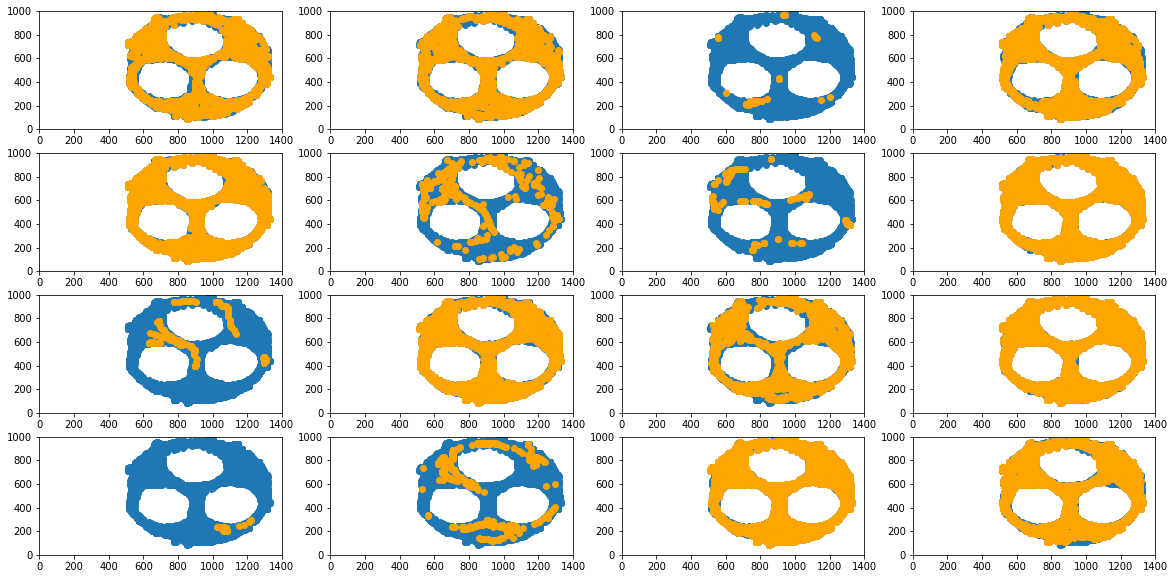

In [15]:
multiplot(scored_mi[:16])
multiplot(scored_si[:16])

## Filtering out neurons
As we see from plots above the neurons which are activated everywhere are scored high. So we should apply some filters in order to find more reliable neurons. Filterings that we can apply are as follows:
* 1-component. Using components obtained on a previous stages of this research we can find neurons that are activated only at some connected subspace.
* Size-Range. In order to filter out neurons that are activated everywhere we can apply filter on number of activation points for each neuron 

In [16]:
ALL_NEURONS=[i for i in range(7,len(data.columns)-7,1)] # Exports have neurons named by columns
MIN_SIZE=1
MAX_SIZE=1000

In [24]:
def component_size(n_neuron: int):
    with open("output/%d.txt"%(n_neuron+7),"r") as f:
        n=f.readlines().count('COMPONENT:\n')
    return n

def activation_size(n_neuron:  int):
    return len(data[str(n_neuron)+".0"][data[str(n_neuron)+".0"]>MU])


In [25]:
neurons=[]
for x in tqdm(data.columns[7:]):
    x=int(x.split(".")[0])
    asz=activation_size(x)
    n_components=component_size(x)
    if n_components>1 or asz<MIN_SIZE or asz>MAX_SIZE:
        data=data.drop(str(x)+".0",axis='columns')
    else:
        neurons.append(x)

100%|██████████| 554/554 [00:07<00:00, 72.65it/s] 


100%|██████████| 27/27 [00:00<00:00, 318.70it/s]


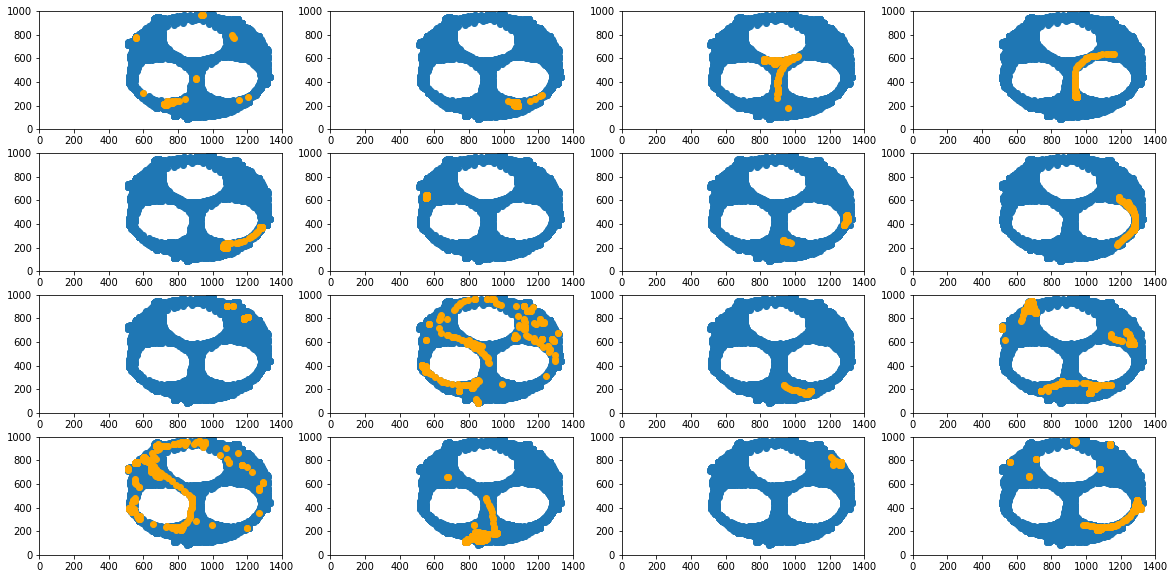

In [26]:
activity=data[data.columns[7:]]
scores=mi_score(activity,labels)
f_scored_mi=[int(data.columns[7+k].split(".")[0]) for k, v in sorted(scores.items(), key=lambda item: item[1])]
multiplot(f_scored_mi[:16])

In [28]:
f_scored_mi[:10]

[527, 320, 384, 90, 23, 418, 103, 403, 201, 447]

100%|██████████| 27/27 [00:03<00:00,  7.31it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

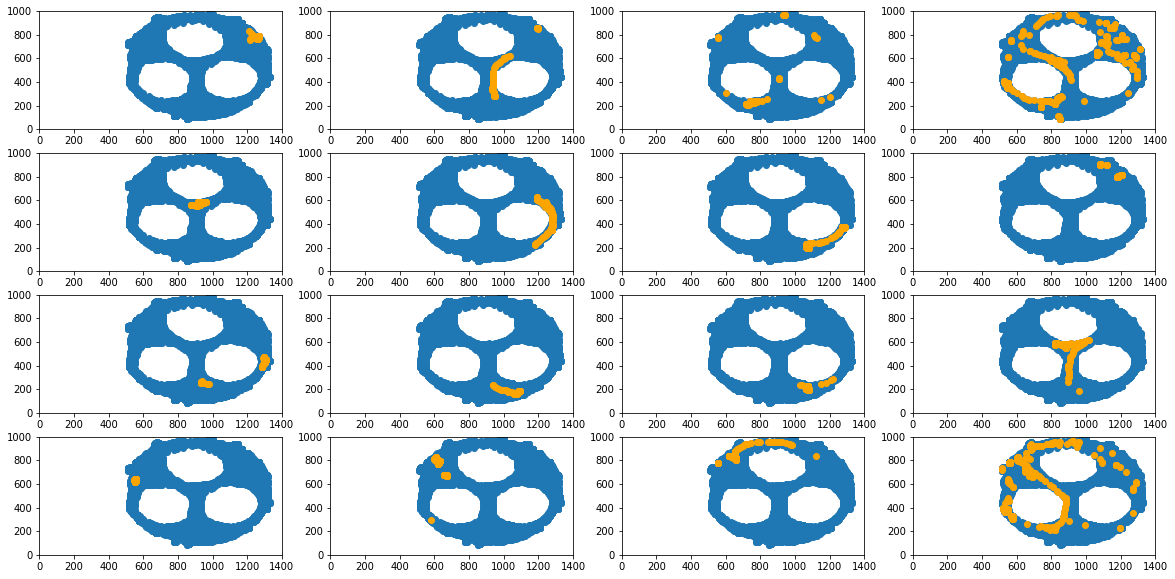

In [32]:
scores=dict()
for x in tqdm(data.columns[7:]):
    i=int(x.split(".")[0])
    scores[i]=(si_score(data[str(i)+".0"],labels))
f_scored_si=[k for k, v in sorted(scores.items(), key=lambda item: item[1])]
multiplot(f_scored_si)

In [33]:
f_scored_si[:10]

[488, 427, 527, 447, 53, 403, 23, 201, 103, 169]